In [1]:
import libtfr

### Whale vocalizations
Source:
- https://github.com/yoavfreund/BeakedWhaleClassification/blob/master/DSE230_version/Data_Processing_Whales.ipynb
- https://datascience.sdsc.edu/project/whale-and-dolphin-sound-classification
- full dataset: https://data.gulfresearchinitiative.org/data/R1.x135.120:0019

In [2]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


In [3]:
import numpy as np
import pandas as pd
from pathlib2 import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tqdm.autonotebook import tqdm
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
whalerepo = Path('/mnt/cube/tsainbur/Projects/github_repos/BeakedWhaleClassification/')
libloc = Path(whalerepo/'Sumit_et_al/lib/').resolve()

In [6]:
columns=[
        "time",
        "species",
        "site",
        "rec_no",
        "bout_i",
        "peak2peak",
        "MSN",
        "MSP",
        "TPWS1",
        "MD1",
        "FD1",
        "TPWS2",
        "MD2",
        "FD2",
        "TPWS3",
        "MD3",
        "FD3",
    ],

In [7]:
def unpackArray(x, data_type=np.int16):
    return np.frombuffer(x, dtype=data_type)

file_data = np.load(
    (whalerepo / "data" / "DSE230_version_Data" / "whale_data_15mb.np").as_posix()
)
song_df = pd.DataFrame(
    file_data,
    columns=[
        "time",
        "species",
        "site",
        "rec_no",
        "bout_i",
        "peak2peak",
        "MSN",
        "MSP",
        "TPWS1",
        "MD1",
        "FD1",
        "TPWS2",
        "MD2",
        "FD2",
        "TPWS3",
        "MD3",
        "FD3",
    ],
)
song_df.MSN = [unpackArray(i,data_type=np.float64) for i in song_df.MSN.values]
song_df.MSP = [unpackArray(i,data_type=np.float64) for i in song_df.MSP.values]

In [8]:
song_df[:3]

,time,species,site,rec_no,bout_i,peak2peak,MSN,MSP,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
0,2010-08-10 11:45:36.626459,Cuviers,DT,01,5,50.2422,"[9.3197, -13.5086, -6.1229, 5.5962, -0.8494, 1...","[-37.7052, -40.2157, -64.4694, -69.3526, -68.2...",1,0,0,1,0,0,0,0,0
1,2010-08-10 11:46:06.004604,Cuviers,DT,01,5,55.0377,"[-2.2228, 6.5712, -14.2926, 8.2005, -1.0006, 2...","[-34.7333, -37.8125, -76.5551, -63.8601, -63.2...",1,0,0,1,0,0,0,0,0
2,2010-08-10 12:11:25.866437,Cuviers,DT,01,5,44.9439,"[5.8497, 0.9312, -1.3678, -1.0723, -4.6082, 0....","[-39.6219, -42.9117, -70.0049, -80.345, -82.53...",1,0,0,1,0,0,0,0,0


In [9]:
len(song_df.MSN.values[0]), len(song_df.MSP.values[0])

(202, 101)

In [10]:
len(song_df)

4175

Cuviers


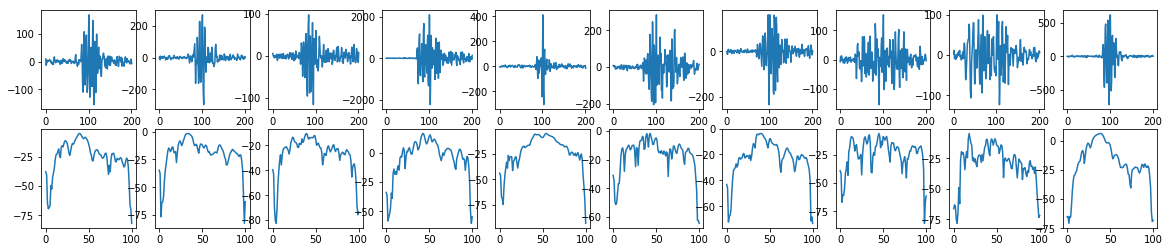

Gervais


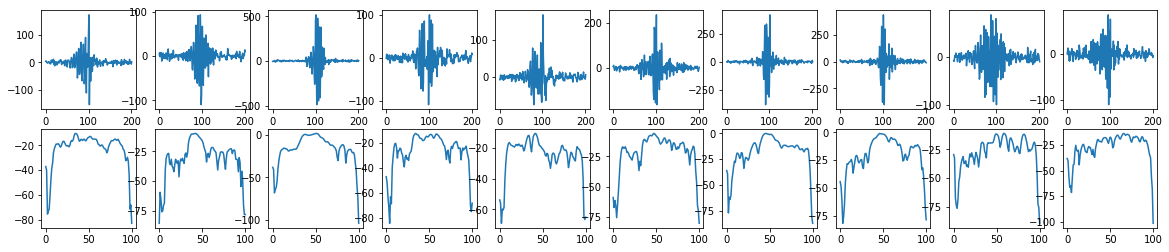

In [11]:
nex = 10
for species in np.unique(song_df.species):
    print(species)
    species_df = song_df[song_df.species==species]
    fig, axs = plt.subplots(nrows=2, ncols=nex, figsize=(nex*2, 2*2))
    for ri, (idx, row) in enumerate(species_df[:nex].iterrows()):
        axs[0,ri].plot(row.MSN)
        axs[1,ri].plot(row.MSP)
    plt.show()

### UMAP of spectra

In [12]:
import umap

In [13]:
spectra = np.vstack(song_df.MSP.values)

In [14]:
fit = umap.UMAP()
%time u = fit.fit_transform(spectra)

CPU times: user 27.1 s, sys: 1.72 s, total: 28.8 s
Wall time: 24.2 s


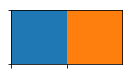

In [15]:
import seaborn as sns
labs = song_df.species.values
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = [lab_dict[i] for i in labs]

(-8.43916368484497, 9.889284610748291)

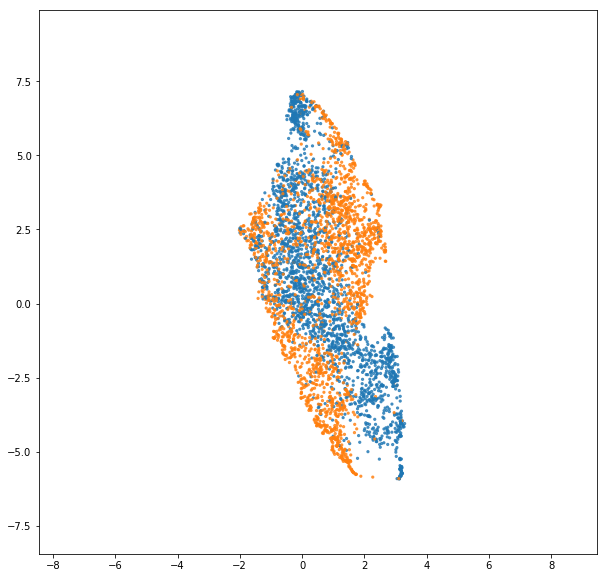

In [16]:
stds = 3
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u[:,0], u[:,1], alpha = 0.75, s=5, color=colors)
ax.set_xlim([np.mean(u[:,0]) - np.std(u[:,0])*stds, np.mean(u[:,0]) + np.std(u[:,0])*stds])
ax.set_ylim([np.mean(u[:,1]) - np.std(u[:,1])*stds, np.mean(u[:,1]) + np.std(u[:,1])*stds])
#ax.set_ylim([-10,10])

In [17]:
np.shape(u)

(4175, 2)

### spectrograms

In [18]:
data = species_df.MSN.values[0]

In [19]:
rate = 16000
win_length_ms = 2
hop_length_ms = .3

In [20]:
int(rate/1000 * win_length_ms)

32

In [21]:
hparams = HParams(  
    # spectrogramming
    win_length = int(rate/1000 * win_length_ms),
    n_fft = 64,
    hop_length= int(rate/1000 * hop_length_ms),
    ref_level_db = 20,
    min_level_db = -75,
    # mel scaling
    num_mel_bins = 64,
    mel_lower_edge_hertz = 3400,
    mel_upper_edge_hertz = 38000,
    # inversion
    power = 1.5, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
    #
)

In [22]:
spectrogram = spectrogram_tensorflow(int16_to_float32(data), hparams)

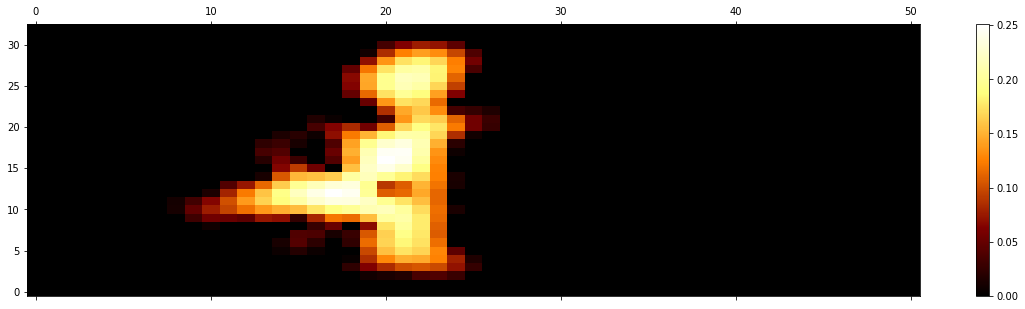

In [23]:
visualize_spec(spectrogram.numpy().T, show=True, cmap = plt.cm.viridis)

Cuviers


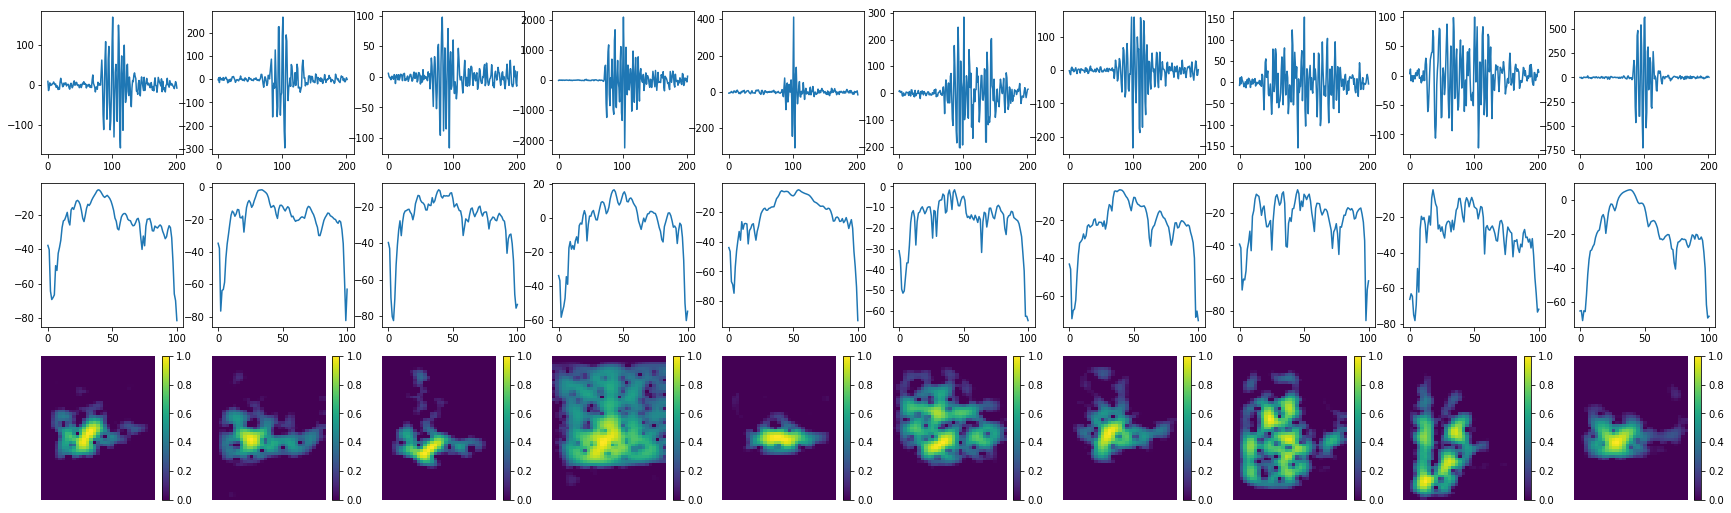

Gervais


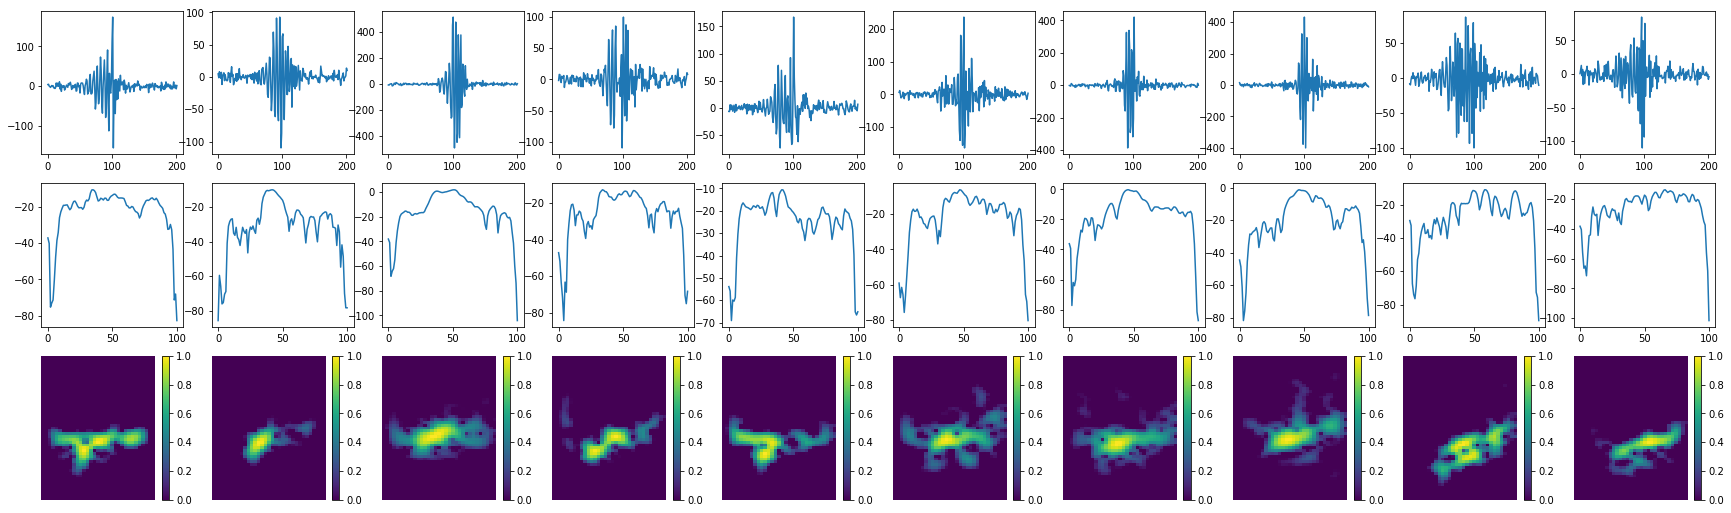

In [24]:
nex = 10
zoom = 3
for species in np.unique(song_df.species):
    print(species)
    species_df = song_df[song_df.species==species]
    fig, axs = plt.subplots(nrows=3, ncols=nex, figsize=(nex*zoom, 3*zoom))
    for ri, (idx, row) in enumerate(species_df[:nex].iterrows()):
        spectrogram = spectrogram_tensorflow(int16_to_float32(row.MSN), hparams)
        spectrogram = spectrogram/np.max(spectrogram)
        axs[0,ri].plot(row.MSN)
        axs[1,ri].plot(row.MSP)
        plot_spec(spectrogram, fig, axs[2,ri], cmap = plt.cm.viridis)
        axs[2,ri].axis('off')
        #axs[2,ri].matshow(spectrogram, origin='lower', )
    plt.show()

### make spectrograms of entire dataset

In [25]:
song_df['spec'] = None
for idx, row in tqdm(song_df.iterrows(), total=len(song_df)):
    try:
        spectrogram = spectrogram_tensorflow(int16_to_float32(row.MSN), hparams)
    except ValueError:
        spectrogram = spectrogram_tensorflow((row.MSN/np.max(np.abs(row.MSN))).astype('float32'), hparams)
    spectrogram = spectrogram/np.max(spectrogram)
    song_df.loc[idx, 'spec'] = spectrogram.numpy()

### UMAP of spectrogram

In [26]:
specs_flattened = [i.flatten() for i in song_df.spec.values]

In [27]:
fit = umap.UMAP()
%time u = fit.fit_transform(specs_flattened)

CPU times: user 22.2 s, sys: 1.75 s, total: 23.9 s
Wall time: 17.2 s


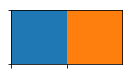

In [28]:
import seaborn as sns
labs = song_df.species.values
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = [lab_dict[i] for i in labs]

(-9.367858201265335, 10.291446417570114)

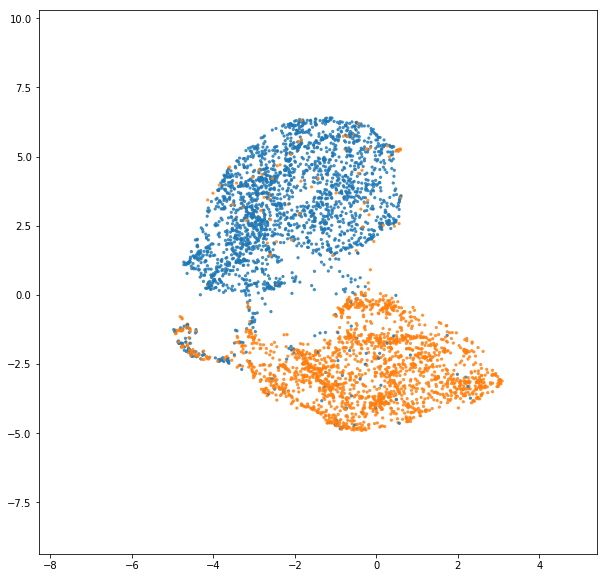

In [29]:
stds = 3
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u[:,0], u[:,1], alpha = 0.75, s=5, color=colors)
ax.set_xlim([np.mean(u[:,0]) - np.std(u[:,0])*stds, np.mean(u[:,0]) + np.std(u[:,0])*stds])
ax.set_ylim([np.mean(u[:,1]) - np.std(u[:,1])*stds, np.mean(u[:,1]) + np.std(u[:,1])*stds])
#ax.set_ylim([-10,10])